# Chaotic time-series dataset generation

In [65]:
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import OptimizeResult
from ddeint import ddeint
import json
import pandas as pd
import warnings
import sys

from cmlUtils import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)

### Mackey-glass

Solution to the time-delay differential equation given by:

$\frac{dx}{dt}=\frac{ax(t-\tau)}{1+x^c(t-\tau)}-bx(t) $

However, the convention for the initial history is not clear. Here, we arbitrarily chose 0.75.

Produce 150,000 data points, spaced at $\delta t=0.1$. We will ultimately save every 10 points as the final, working dataset of 15,000 points.

In [2]:
condMakeDir('datasets')
model = lambda x,t, a,b,c,tau : (a*x(t-tau))/(1+(x(t-tau)**c)) - b*x(t)
for x in np.arange(0.2,1,0.05):
    print(f'starting: {x}')
    gval = x
    g = lambda t: gval
    steps = 150001
    dt = 0.1

    tt = np.arange(0,steps)*dt
    yy = ddeint(model, g, tt, fargs=(0.2, 0.1, 10, 17)) # a=0.2, b=0.1, c=10, tau=17

    s = 10 # sampling rate

    yy = np.array([x[0] if type(x)==np.ndarray else x for x in yy])

    tt_sampled = tt[::s].copy()
    yy_sampled = yy[::s].copy()

    mg = np.array(list(zip(tt_sampled,yy_sampled)))
    pd.DataFrame(mg).to_csv(f'./datasets/py-mackey-glass_g={gval:.02f}_T={int(tt[-1])}_dt={dt*s}.csv', header=None, index=None)

starting: 0.2
starting: 0.25
starting: 0.3
starting: 0.35
starting: 0.39999999999999997
starting: 0.44999999999999996
starting: 0.49999999999999994
starting: 0.5499999999999999
starting: 0.5999999999999999
starting: 0.6499999999999999
starting: 0.7
starting: 0.7499999999999998
starting: 0.7999999999999998
starting: 0.8499999999999999
starting: 0.8999999999999999
starting: 0.9499999999999997


### Lorenz

Solution to the Lorenz system of differential equations given by:

$
\begin{cases}
\frac{dx}{dt} &= a(y-x)\\
\frac{dy}{dt} &= x(b-z)-y\\
\frac{dz}{dt} &= xy-cz
\end{cases}
$

where

$
a=10,b=28,c=\frac{8}{3}
$

However, the convention for the initial conditions is not clear. Here, we arbitrarily chose $\mathbf{x}=(x_0,y_0,z_0)=(-3,-3,28)$.

In [3]:
def saveData(t_arr, x_arr, y_arr, z_arr, dt, filenamehead, method, subdir=''):
    data_cols = np.column_stack([x_arr, y_arr, z_arr])

    lorenz = np.column_stack([t_arr, data_cols])

    pd.DataFrame(lorenz).to_csv(f'{subdir}{filenamehead}_{method}_T={int(t_arr[-1])}_dt={dt}.csv', header=None, index=None)

In [58]:
t0 = 0
dt = 0.01
y0 = np.array([-3,-3,28])
tf_arr = [100,200,300,400,500]
sol_arr_arr = []

solve_ivp_methods = [
    'RK23',     # 
    'RK45',     #
    'DOP853',   #
    'Radau',    #
    'BDF',      #
    'LSODA'     #
]

for tf in tf_arr:
    sol_arr = []
    tt = np.arange(t0,tf+dt,dt)

    # Naïve 4th-order Runge-Kutta
    sol = RK4(dlorenz, y0, tt, args=(10,28,8/3,0,0,0))
    saveData(sol.t, sol.y[0,:], sol.y[1,:], sol.y[2,:], dt, 'py-lorenz', 'RK4', subdir='./datasets/')
    sol_arr.append(sol)

    # "Noisy"/Imperfect Knowledge Naïve 4th-order Runge-Kutta
    sol = RK4(dlorenz, y0, tt, args=(10,28,8/3,0,0.05,0))
    saveData(sol.t, sol.y[0,:], sol.y[1,:], sol.y[2,:], dt, 'py-lorenz', 'RK4_noisy', subdir='./datasets/')
    sol_arr.append(sol)

    for m in solve_ivp_methods:
        sol = solve_ivp(dlorenz, (t0, tf+dt), y0, method=m, t_eval = tt, max_step = 0.01, args=(10,28,8/3,0,0,0), vectorized=True)
        saveData(sol.t, sol.y[0,:], sol.y[1,:], sol.y[2,:], dt, 'py-lorenz', m, subdir='./datasets/')
        sol_arr.append(sol)
    
    sol_arr_arr.append(sol_arr)

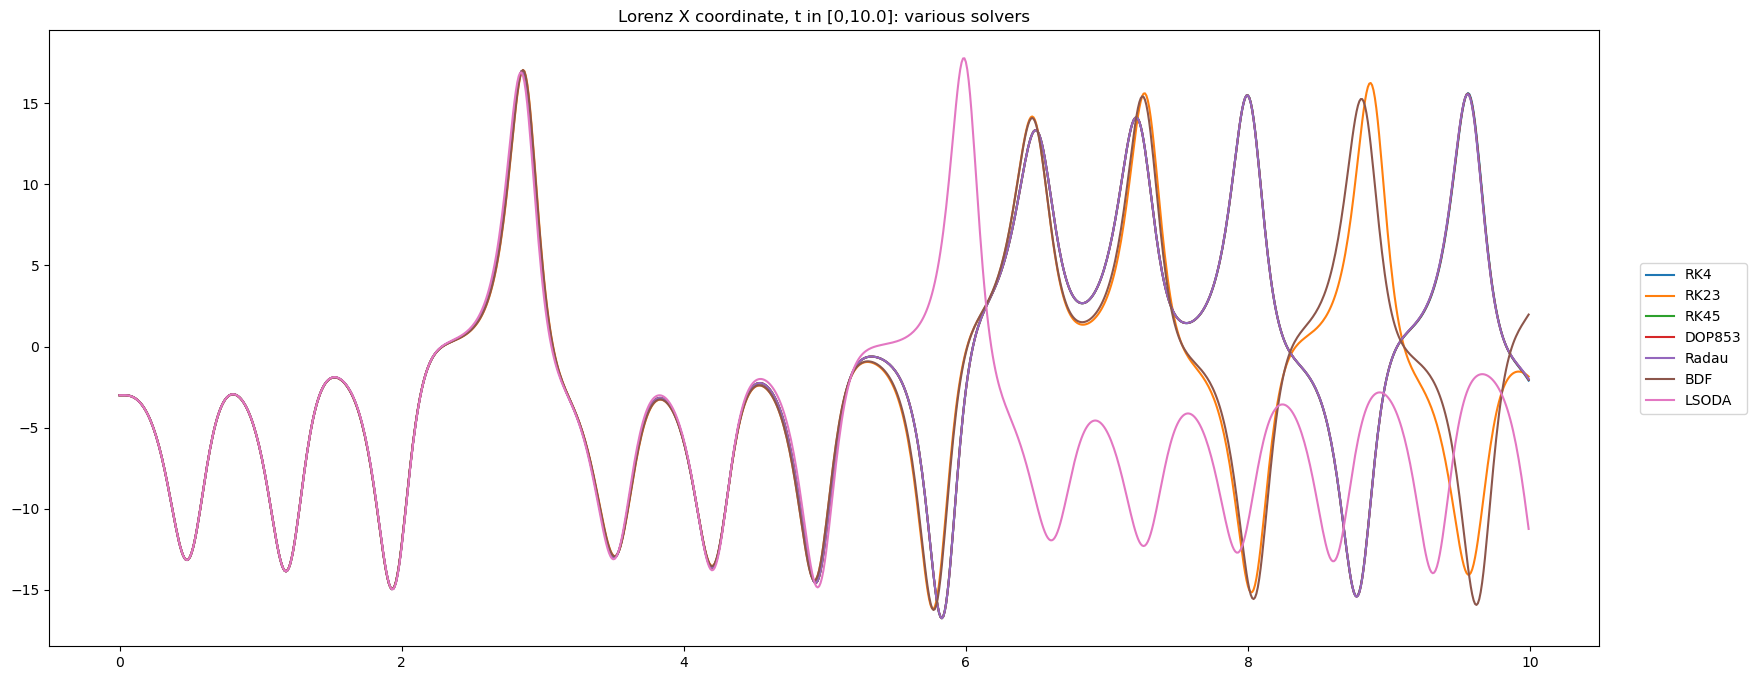

In [61]:
tf_idx = 4
tf = tf_arr[tf_idx]
tt = np.arange(t0,tf+dt,dt)

num_pts = 1000

fig, axs = plt.subplots(1, figsize=(20, 8))
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][0].y[0,:num_pts], label="RK4")
# axs.plot(tt[:num_pts], sol_arr[1][:num_pts,0], label="Noisy RK4")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][2].y[0,:num_pts], label="RK23")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][3].y[0,:num_pts], label="RK45")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][4].y[0,:num_pts], label="DOP853")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][5].y[0,:num_pts], label="Radau")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][6].y[0,:num_pts], label="BDF")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][7].y[0,:num_pts], label="LSODA")
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs.set_title(f'Lorenz X coordinate, t in [0,{tt[num_pts]}]: various solvers')
plt.show()

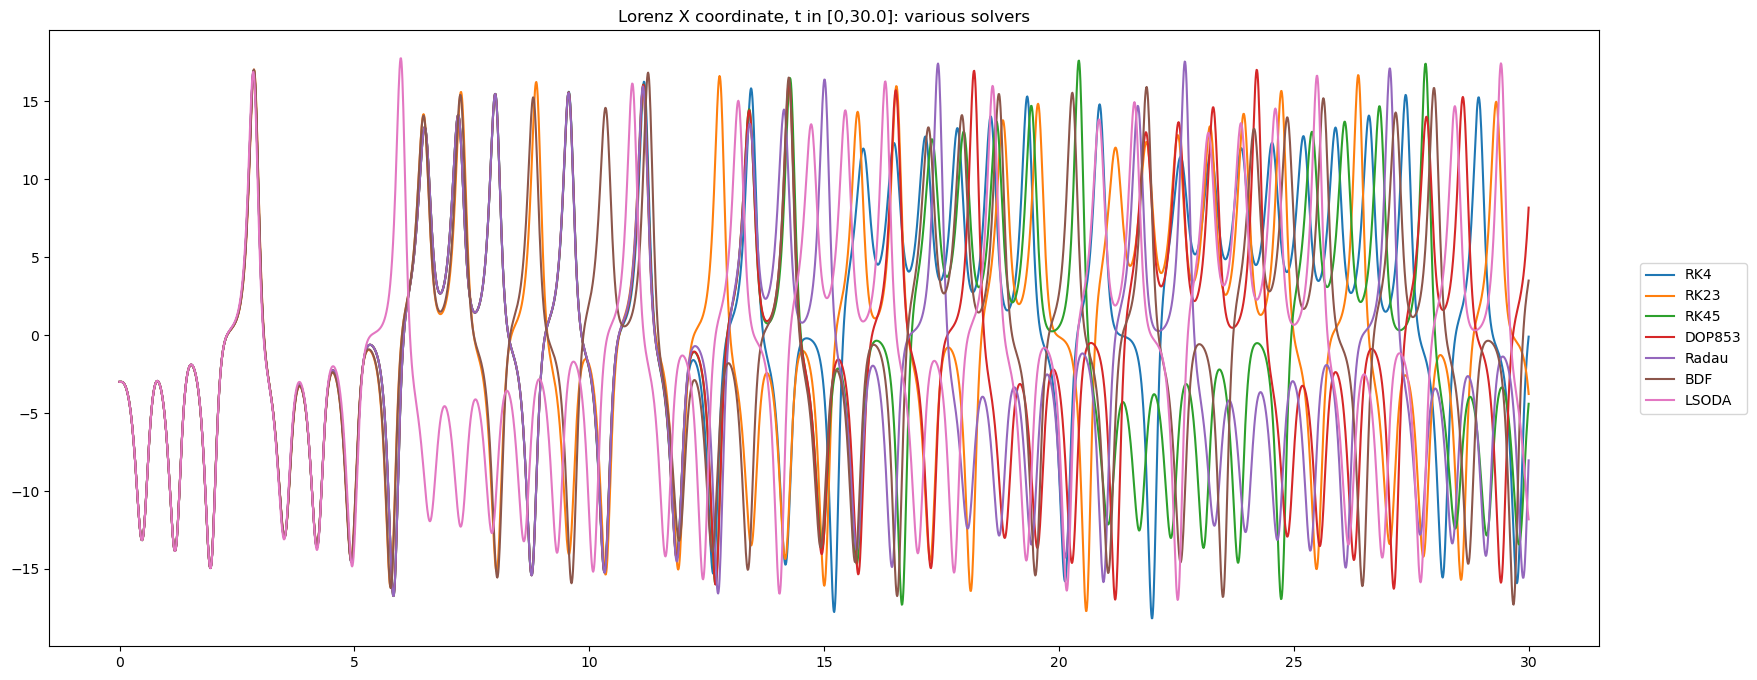

In [62]:
num_pts = 3000

fig, axs = plt.subplots(1, figsize=(20, 8))
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][0].y[0,:num_pts], label="RK4")
# axs.plot(tt[:num_pts], sol_arr[1][:num_pts,0], label="Noisy RK4")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][2].y[0,:num_pts], label="RK23")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][3].y[0,:num_pts], label="RK45")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][4].y[0,:num_pts], label="DOP853")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][5].y[0,:num_pts], label="Radau")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][6].y[0,:num_pts], label="BDF")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][7].y[0,:num_pts], label="LSODA")
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs.set_title(f'Lorenz X coordinate, t in [0,{tt[num_pts]}]: various solvers')
plt.show()

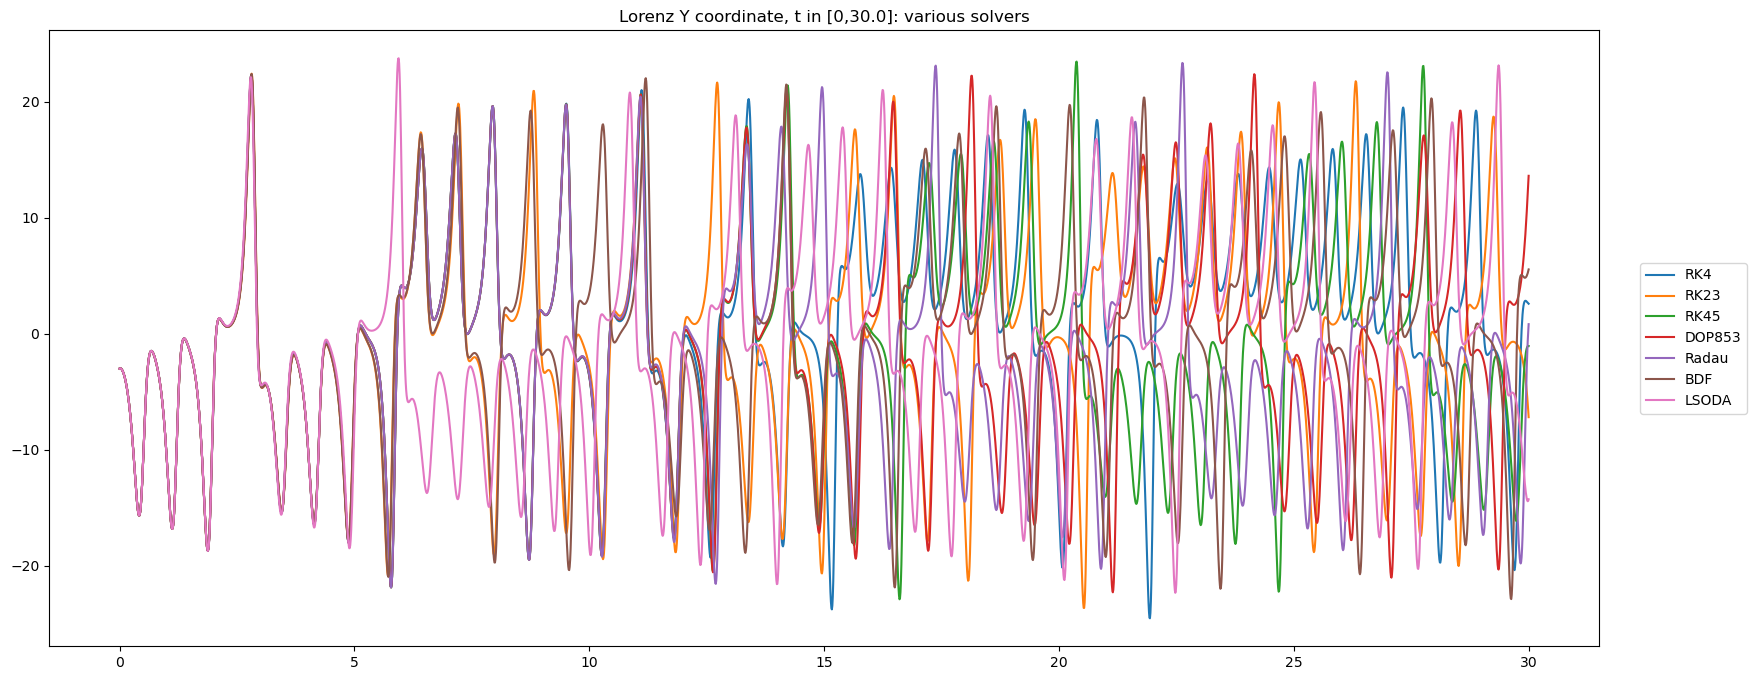

In [63]:
num_pts = 3000

fig, axs = plt.subplots(1, figsize=(20, 8))
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][0].y[1,:num_pts], label="RK4")
# axs.plot(tt[:num_pts], sol_arr[1][:num_pts,0], label="Noisy RK4")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][2].y[1,:num_pts], label="RK23")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][3].y[1,:num_pts], label="RK45")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][4].y[1,:num_pts], label="DOP853")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][5].y[1,:num_pts], label="Radau")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][6].y[1,:num_pts], label="BDF")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][7].y[1,:num_pts], label="LSODA")
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs.set_title(f'Lorenz Y coordinate, t in [0,{tt[num_pts]}]: various solvers')
plt.show()

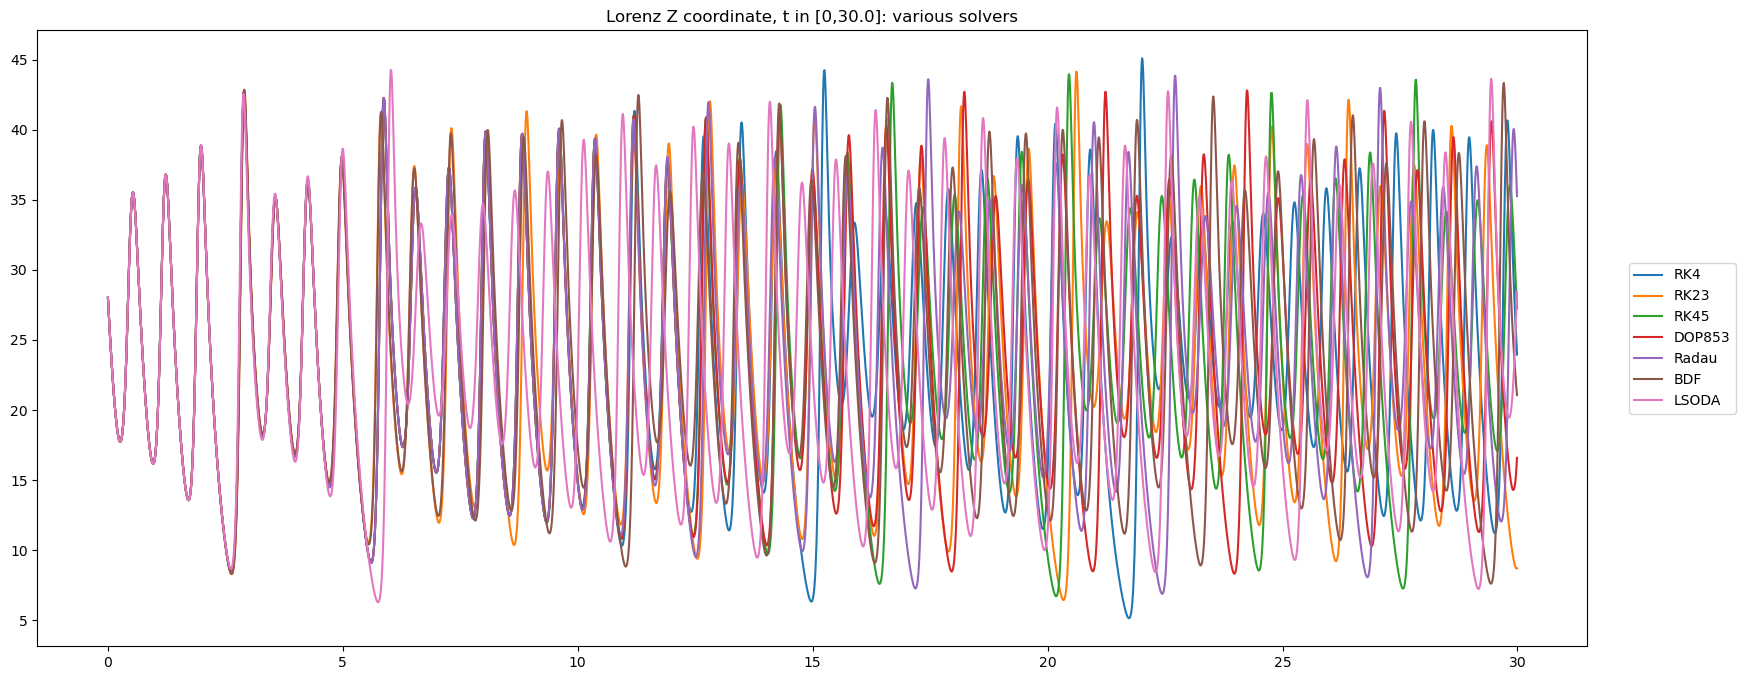

In [64]:
num_pts = 3000

fig, axs = plt.subplots(1, figsize=(20, 8))
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][0].y[2,:num_pts], label="RK4")
# axs.plot(tt[:num_pts], sol_arr[1][:num_pts,0], label="Noisy RK4")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][2].y[2,:num_pts], label="RK23")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][3].y[2,:num_pts], label="RK45")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][4].y[2,:num_pts], label="DOP853")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][5].y[2,:num_pts], label="Radau")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][6].y[2,:num_pts], label="BDF")
axs.plot(tt[:num_pts], sol_arr_arr[tf_idx][7].y[2,:num_pts], label="LSODA")
axs.legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs.set_title(f'Lorenz Z coordinate, t in [0,{tt[num_pts]}]: various solvers')
plt.show()